# Undersampling

This notebook discusses Multi-label classification methods using undersampling for the [academia.stackexchange.com](https://academia.stackexchange.com/).

A classifier is trained for each label individually. The training data for each classifier is adjusted using *undersampling*.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_X_reduced, get_y, get_test_train_data
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition

def get_X():
    return np.vstack([document.text for document in documents])
y = get_y()

X_train, X_test, y_train, y_test = get_test_train_data(get_X(), y, scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

preprocessing = PreprocessingDefinition('tfidf', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = get_test_train_data(get_X_reduced(preprocessing), y)

preprocessing = PreprocessingDefinition('count', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_count, X_test_count, y_train_count, y_test_count = get_test_train_data(get_X_reduced(preprocessing), y)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import word2vec, doc2vec, fasttext2vec

In [4]:
def get_data(embedding):
    if embedding == 'word2vec':
        X_train_, X_test_ = word2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'doc2vec':
        X_train_, X_test_ = doc2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'fasttext':
        X_train_, X_test_ = fasttext2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'tfidf':
        return X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf
    elif embedding == 'count':
        return X_train_count, X_test_count, y_train_count, y_test_count

In [5]:
paths = available_classifier_paths('classwise')
def create_classifier(classifier_options, name, embedding):
    path = [path for path in paths if name in path.name and embedding in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        preprocessing = PreprocessingDefinition(embedding, 'basic', 'basic', 'english', '1,1', 'None')
        classifier = ClasswiseClassifier(classifier_options, embedding, undersample=True)
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_, y_train_, y_test_ = get_data(embedding)
        clf.fit(X_train_, y_train_)
        clf.score(X_test_, y_test_)
        clf.save('classwise')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='training'/>

## Training

The [Classwise Classifier](../classwise_classifier.py) is trained for three different classification methods.
- Linear SVC
- Logistic Regression
- MLPClassifier

As seen in [notebook 1.0](1.0-me-initial-data-exploration.ipynb) the data for each label is unbalanced. The majority class is generally present for ~90% of the data. Leading to a very high probability for the majority class: the label not being predicted. Since the final application is supposed to act as a recommender, it should prioritise to predict if there is any chance of that label fitting the sample. Undersampling can help to balance this issue.
Instead of handing all samples to the classifier, a more balanced ratio is used as training data. The [Classwise Classifier](../classwise_classifier.py) uses a ratio of 1:25, depending on how many positive samples are available in the original data.

In [6]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

**Word2Vec**

In [7]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'word2vec')

Training: 19.718268394470215s
Test: 2.074974775314331s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013021065359893082     0.05900846432889964      0.3764788583712404       0.2578395808141878       0.2776816378569704       
micro                                                            0.52551072785135         0.24426206040940973      0.33350706886442116      
macro                                                            0.3575749158306797       0.2345395987890216       0.2386451114068064       


In [8]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'word2vec')

Training: 17.205244541168213s
Test: 2.0953938961029053s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012397377967288233     0.0656590084643289       0.33678758565094724      0.19953647722692464      0.23118774548036944      
micro                                                            0.6149774248793398       0.1884811757408026       0.2885317750182615       
macro                                                            0.3562172888115042       0.10820842851285602      0.14622916982704665      


In [9]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'word2vec')

Training: 1647.9664335250854s
Test: 9.159232139587402s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01722713676573538      0.02769044740024184      0.3898978758712737       0.4055542120112857       0.3590635164244596       
micro                                                            0.3640176600441501       0.3943278014252236       0.3785670010789964       
macro                                                            0.24934125183875896      0.3818064643609824       0.27637937752642344      


**Doc2Vec**

In [10]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'doc2vec')

Training: 236.29339241981506s
Test: 4.5645973682403564s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.026466619996181506     0.01837968561064087      0.13211551450740036      0.2029826682789198       0.13427665536029554      
micro                                                            0.14512308167679472      0.20211341684995696      0.16894146799624307      
macro                                                            0.18923915221379564      0.2917490769792058       0.1474269724482509       


In [11]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'doc2vec')

Training: 28.666009426116943s
Test: 4.845218181610107s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.023530197925284796     0.0249093107617896       0.1901111150290784       0.2524022571543732       0.17966960510399627      
micro                                                            0.19889751378107773      0.253610021994836        0.22294613396103485      
macro                                                            0.18035192777080505      0.3093946483874893       0.17858488702276099      


In [12]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'doc2vec')

Training: 1239.3043859004974s
Test: 9.466374397277832s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.023550563227900466     0.015961305925030228     0.2633694968607284       0.33567110036275694      0.25969652457446174      
micro                                                            0.23280528710438045      0.3351821746198719       0.2747672709456149       
macro                                                            0.18284018384144884      0.3634212053424727       0.21648380713777066      


**FastText**

In [13]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'fasttext')

Training: 19.933865308761597s
Test: 2.2140889167785645s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012653217081397569     0.06529625151148731      0.39919430529164507      0.27055622732769047      0.2930350665054413       
micro                                                            0.552607124419205        0.2560643031433903       0.3499640358333879       
macro                                                            0.3921265007118315       0.25326295063419635      0.266572946080915        


In [14]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'fasttext')

Training: 17.388831615447998s
Test: 2.0814297199249268s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012268185578820085     0.06916565900846433      0.31386782403408764      0.1828738411930673       0.21377049123119257      
micro                                                            0.6471547662196449       0.17085306923113727      0.27033574321511034      
macro                                                            0.3307032275024187       0.0825951065912333       0.11826968610554156      


In [15]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'fasttext')

Training: 1775.4142796993256s
Test: 10.122425079345703s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017216954114427543     0.032769044740024185     0.3986040768420009       0.41221281741233373      0.3636419299491539       
micro                                                            0.3656520598268171       0.399875651633268        0.3819988577955454       
macro                                                            0.2664645713968164       0.4136128256979451       0.2951912417082317       


**TFIDF**

In [16]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'tfidf')

Training: 745.1395492553711s
Test: 17.54736018180847s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01672882326735824      0.0339782345828295       0.37634877449569104      0.383037081821846        0.34860834047049283      
micro                                                            0.3740885355412335       0.37987866048822433      0.3769613652524295       
macro                                                            0.40701683241452563      0.3593824826780257       0.376249039962208        


In [17]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'tfidf')

Training: 302.9412591457367s
Test: 16.488406658172607s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01291732959969452      0.06928657799274486      0.436804715840387        0.309328899637243        0.3355569252727657       
micro                                                            0.5263856621307667       0.303062150671189        0.3846596938002122       
macro                                                            0.5374363144902626       0.2331069986086446       0.31329485792578804      


In [18]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'tfidf')

Training: 9978.579530715942s
Test: 57.48524832725525s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.0335238337682174       0.007013301088270859     0.20948746552727124      0.3801390568319226       0.24223544097181146      
micro                                                            0.1648952962222456       0.37612212567807596      0.22927457349369385      
macro                                                            0.18012445385071077      0.44908395492163816      0.2016217308255369       


**Count**

In [19]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'count')

Training: 1006.0111207962036s
Test: 16.86844515800476s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.025703557563800675     0.023821039903264812     0.26993311865064745      0.3456247480854494       0.2653539361826524       
micro                                                            0.2133976073601599       0.3475846220136927       0.264442339914038        
macro                                                            0.23939061541004178      0.2978373836240623       0.25715490470102176      


In [20]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'count')

Training: 324.992662191391s
Test: 16.8430335521698s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015094507732450836     0.04836759371221282      0.30990322253321045      0.22296049979846838      0.23590878555812048      
micro                                                            0.3834307831672569       0.22291377411787236      0.28192552225249773      
macro                                                            0.42451477198616216      0.1534587853212733       0.21431193496381576      


In [21]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'count')

Training: 8338.8401222229s
Test: 58.68460416793823s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.04096989753707121      0.01717049576783555      0.22160865325357565      0.3543389762192664       0.22916418977839267      
micro                                                            0.12659488606116806      0.35294680901996456      0.1863498483316481       
macro                                                            0.1180276937041306       0.39644203627972646      0.15225410117656324      


<a id='evaluation'/>

## Evaluation

In [22]:
paths = available_classifier_paths('classwise')
paths = [path for path in paths if 'undersampled' in path.name]

In [23]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf) + ' ' + str(clf.preprocessing.vectorizer), evaluation])

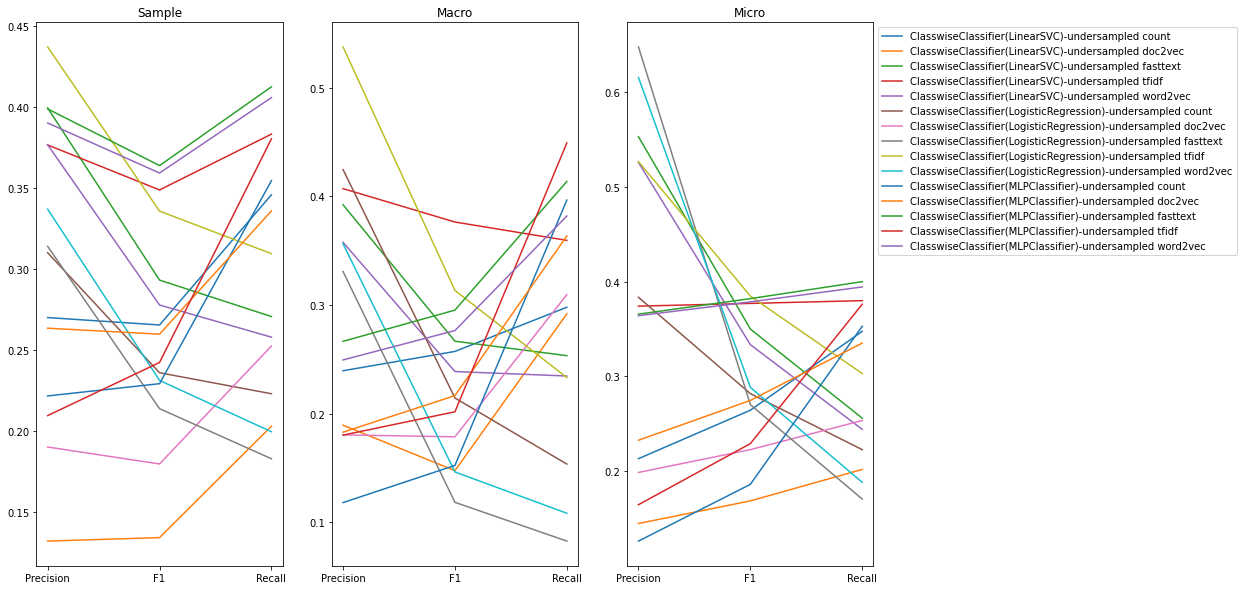

In [24]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [25]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [26]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [27]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    _, X_test_, _, y_test_ = get_data(clf.preprocessing.vectorizer)
    prediction = clf.predict(X_test_)
    label_accuracies = per_label_accuracy(y_test_, prediction)
    report = classification_report(y_test_, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((str(clf) + ' ' + str(clf.preprocessing.vectorizer), classwise_report))

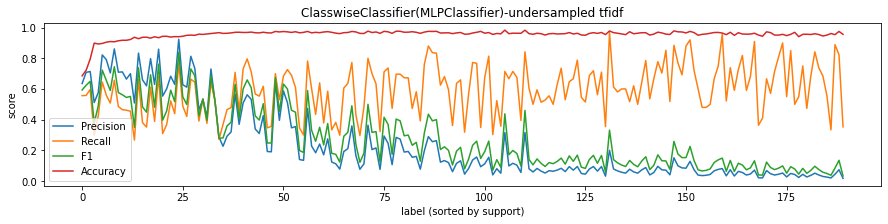

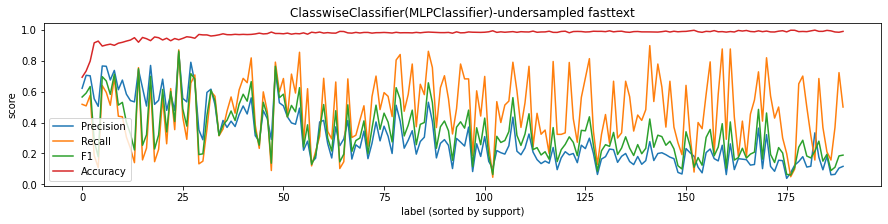

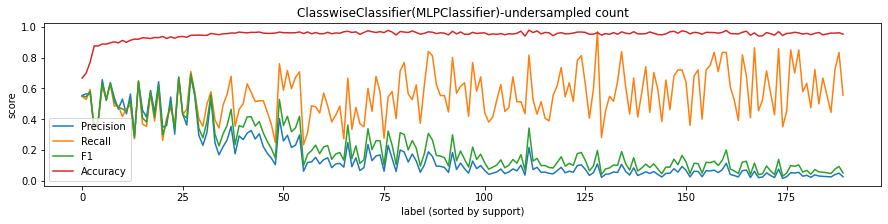

In [28]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()